# Pcakages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
from collections import Counter
import itertools

In [2]:
#Display full contents of a dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Dataset

In [4]:
df=pd.read_csv('C:/Users/seagu/OneDrive/Paris/ds_take_home_challenges/Employee Retention/employee_retention_data.csv')
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  int32         
 1   company_id   24702 non-null  int64         
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
 7   Retained     24702 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(2), int64(2), object(1)
memory usage: 1.3+ MB


In [5]:
df['employee_id']=df['employee_id'].astype(int)

df['join_date']= pd.to_datetime(df['join_date'])
df['quit_date']= pd.to_datetime(df['quit_date'])

#Here, instead of using notna(), we use isna() to get a boolean mask indicating which entries are NaT (Not a Time) values, representing employees who have not quit the company. 
#Then, converting the boolean mask to integers using astype(int) will convert NaT values to 0 and non-NaT values to 1, which represents whether an employee has quit the company or not.
df['Retained'] = pd.to_datetime(df['quit_date'], errors='coerce').isna().astype(int)

In [83]:
data_types  = ["float32","float64","int32","int64","object","category","datetime64[ns]"]

def display_data_description(data, Numerical_data_types, categorical_data_types):
    
    print("Data Description :")
    display(data.describe().T)
    display(data.describe(include=np.object).T)

display_data_description(df,data_types[0:4] ,data_types[4:7])

Data Description :


,count,mean,std,min,25%,50%,75%,max
employee_id,24702.0,501604.403530,288909.026101,36.0,250133.75,500793.0,753137.25,999969.0
company_id,24702.0,3.426969,2.700011,1.0,1.00,2.0,5.00,12.0
seniority,24702.0,14.127803,8.089520,1.0,7.00,14.0,21.00,99.0
salary,24702.0,138183.345478,76058.184573,17000.0,79000.00,123000.0,187000.00,408000.0
Retained,24702.0,0.453081,0.497804,0.0,0.00,0.0,1.00,1.0


C:\Users\seagu\AppData\Local\Temp\ipykernel_25568\1043939486.py:7: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  display(data.describe(include=np.object).T)


,count,unique,top,freq
dept,24702,6,customer_service,9180


In [19]:
# check for unique value
def check_data_unique(df):
    for column in df.columns:
        uniques = df[column].unique()
        print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:10])
check_data_unique(df)

employee_id          24700	 [ 13021 825355 927315 662910 256971 509529  88600 716309 172999 504159]
company_id              12	 [ 7  4  2  9  1  6 10  5  3  8]
dept                     6	 ['customer_service' 'marketing' 'data_science' 'engineer' 'sales' 'design']
seniority               29	 [28 20 14 23 21  4  7 13 17  1]
salary                 367	 [ 89000. 183000. 101000. 115000. 276000. 165000. 107000.  30000. 160000.
 104000.]
join_date              995	 ['2014-03-24T00:00:00.000000000' '2013-04-29T00:00:00.000000000'
 '2014-10-13T00:00:00.000000000' '2012-05-14T00:00:00.000000000'
 '2011-10-17T00:00:00.000000000' '2012-01-30T00:00:00.000000000'
 '2013-10-21T00:00:00.000000000' '2014-03-05T00:00:00.000000000'
 '2012-12-10T00:00:00.000000000' '2012-06-12T00:00:00.000000000']
quit_date              665	 ['2015-10-30T00:00:00.000000000' '2014-04-04T00:00:00.000000000'
                           'NaT' '2013-06-07T00:00:00.000000000'
 '2014-08-22T00:00:00.000000000' '2013-08-30T00:00:00

In [84]:
#Draw Boxplot for all Numerical Values
def Boxplot_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols,figsize=(16,16))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(dataset[data], ax=axs[i])
        axs[i].set_title('Boxplot of '+ data)

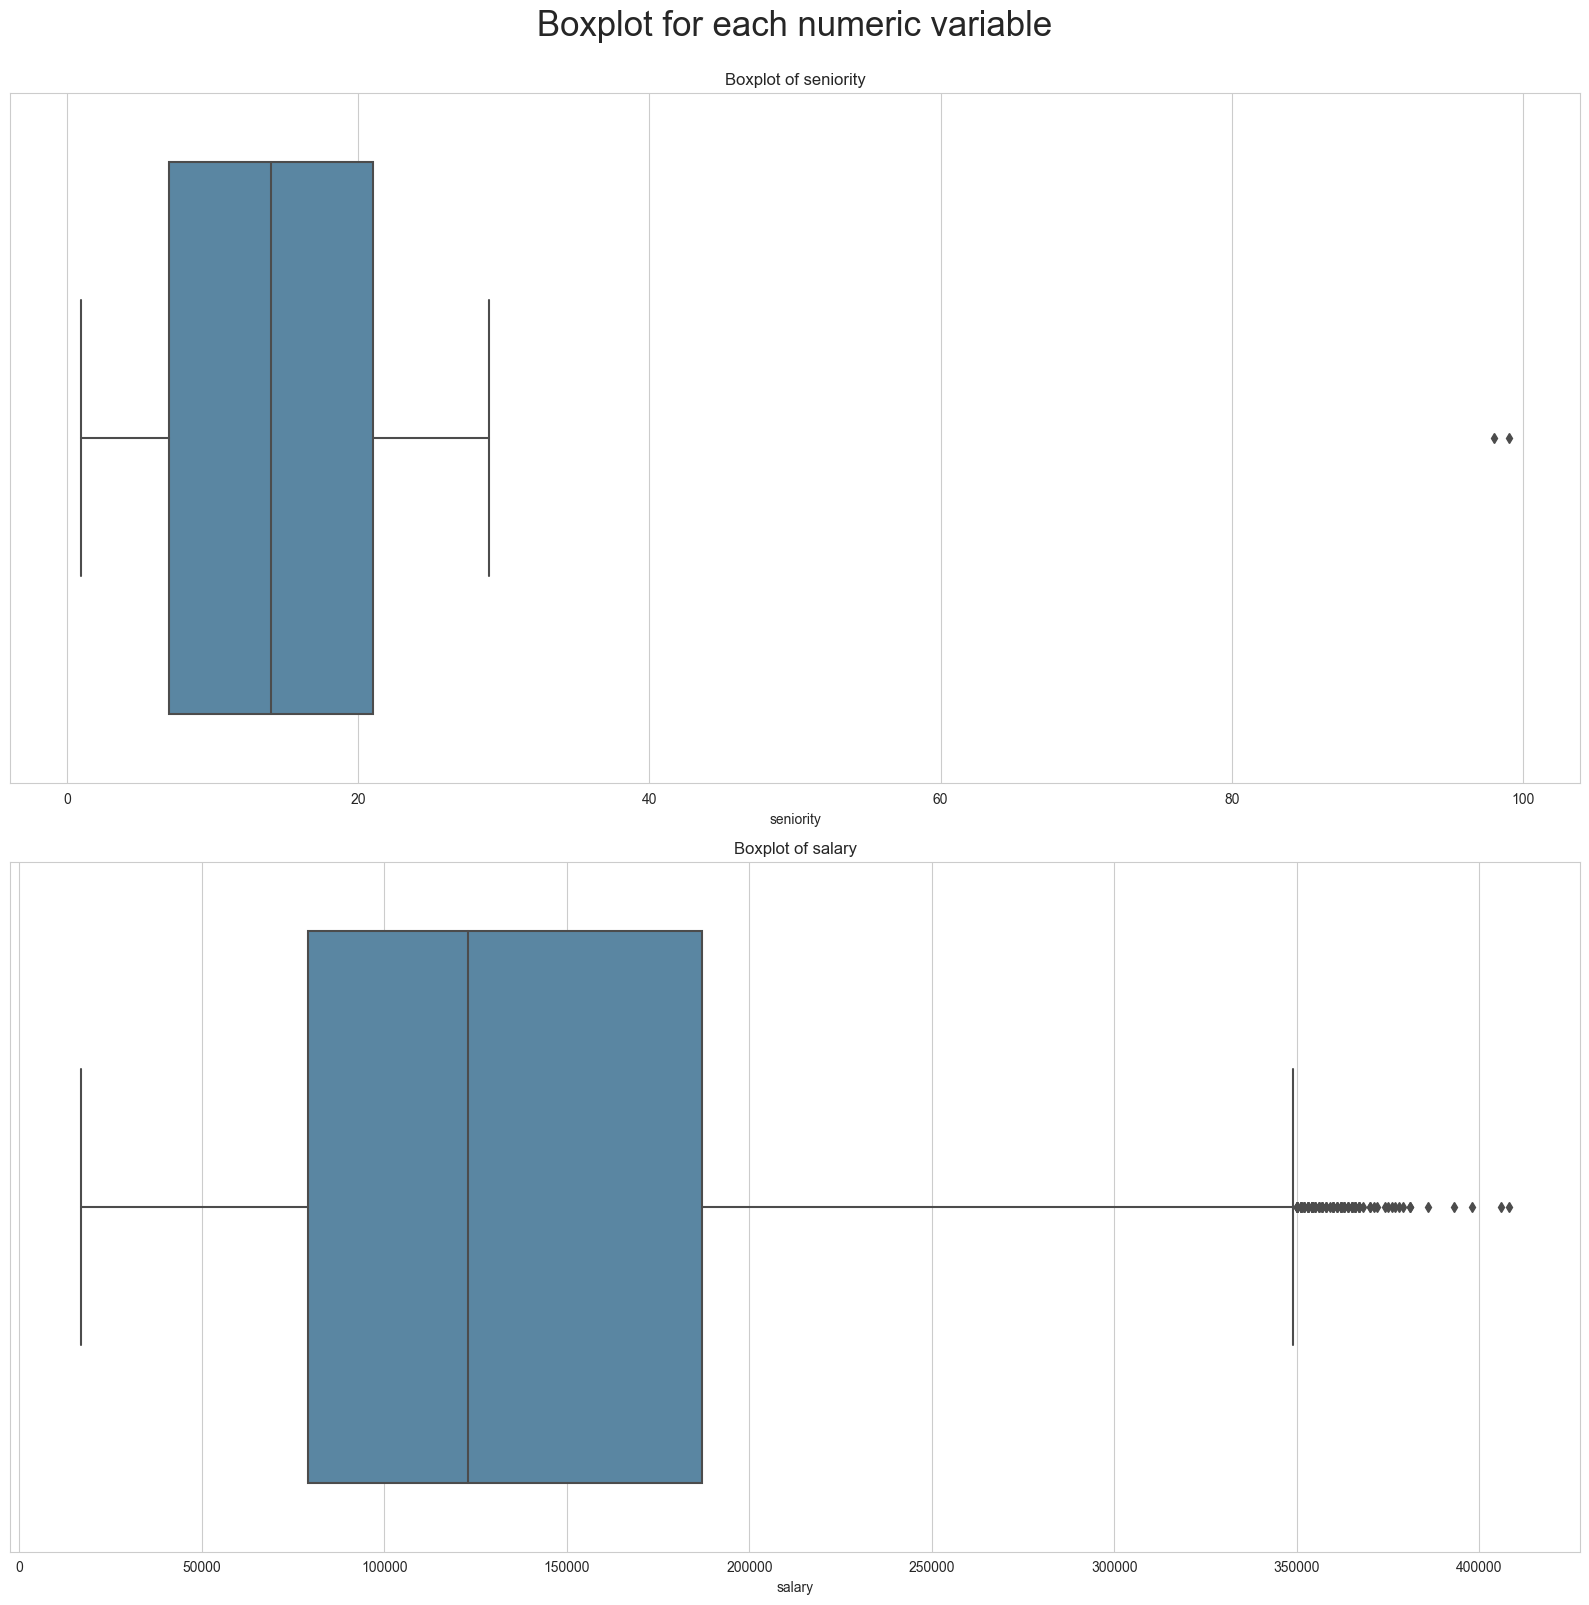

In [85]:
numeric_columns=df[['seniority','salary']]

Boxplot_custom(dataset=df, columns_list=numeric_columns, rows=2, cols=1, suptitle='Boxplot for each numeric variable')
plt.tight_layout()

In [6]:
# remove outliers in seniority
df=df[df['seniority']<80]

In [20]:
#check missing value
null_df = df.isnull().sum() / df.shape[0] * 100
null_df

employee_id    0.000000 
company_id     0.000000 
dept           0.000000 
seniority      0.000000 
salary         0.000000 
join_date      0.000000 
quit_date      45.311741
Retained       0.000000 
dtype: float64

In [21]:
# Check for duplicate 
print('Duplicated value(s) in our dataset : ', df.duplicated().sum())

Duplicated value(s) in our dataset :  0


In [7]:
df['Retention_Or_Not'] = df.loc[:, 'Retained']
df['Retention_Or_Not'].replace([1, 0],
                        ['Retained', 'Churned'], inplace=True)

In [8]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,Retained,Retention_Or_Not
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,Churned
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,Churned
2,927315,4,marketing,14,101000.0,2014-10-13,NaT,1,Retained
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,Churned
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,Churned


# EDA

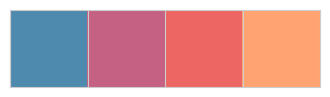

In [9]:
sns.set_style("whitegrid")
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))

sns.palplot(sns.color_palette(custom_colors),size=1)
plt.tick_params(axis='both', labelsize=0, length = 0)

<AxesSubplot: title={'center': 'Target Variable Distribution'}, ylabel='Retained'>

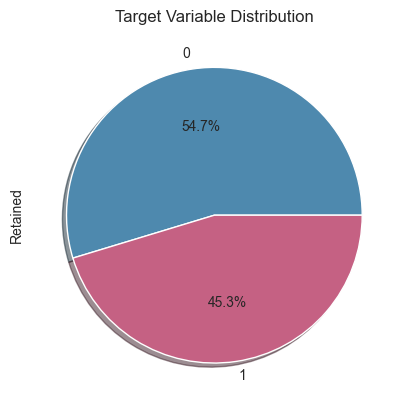

In [93]:
df['Retained'].value_counts().plot.pie(title="Target Variable Distribution",autopct='%1.1f%%',shadow=True,startangle=0)
plt.show()

In [39]:
def barPerc(df,xVar,ax):
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable 
        ax: Axes object (for Seaborn Countplot/Bar plot or
                         pandas bar plot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom", fontsize = 7.5)

<Figure size 800x500 with 0 Axes>

Text(0.5, 1.0, 'Department VS Employee Retention')

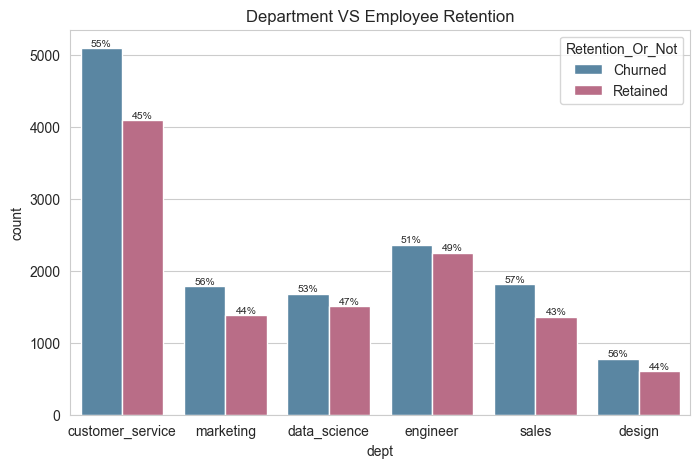

In [94]:
plt.figure(figsize=[8,5])
ax=sns.countplot(x='dept',hue='Retention_Or_Not',data=df)
barPerc(df,'dept',ax)
plt.title('Department VS Employee Retention')
plt.show()

<Figure size 800x500 with 0 Axes>

Text(0.5, 1.0, 'Company VS Employee Retention')

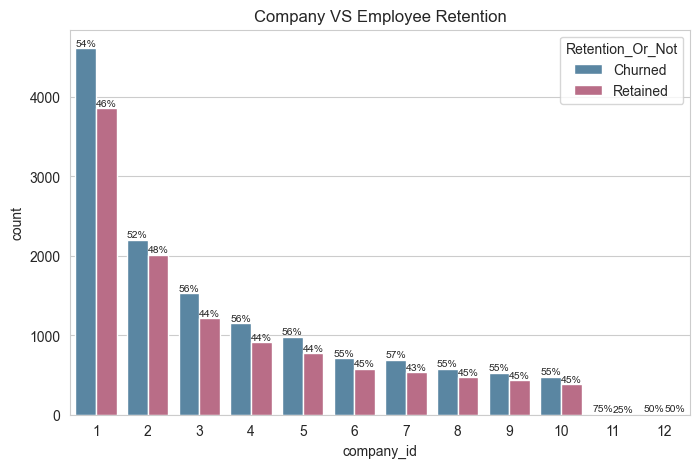

In [95]:
plt.figure(figsize=[8,5])
ax=sns.countplot(x='company_id',hue='Retention_Or_Not',data=df)
barPerc(df,'company_id',ax)
plt.title('Company VS Employee Retention')
plt.show()

<AxesSubplot: xlabel='salary', ylabel='Count'>

<AxesSubplot: xlabel='salary', ylabel='Retention_Or_Not'>

Text(0, 0.5, '')

[Text(0, 0, 'Retained'), Text(0, 1, 'Churned')]

Text(0.5, 0.98, 'Salary distribution by Target Variable')

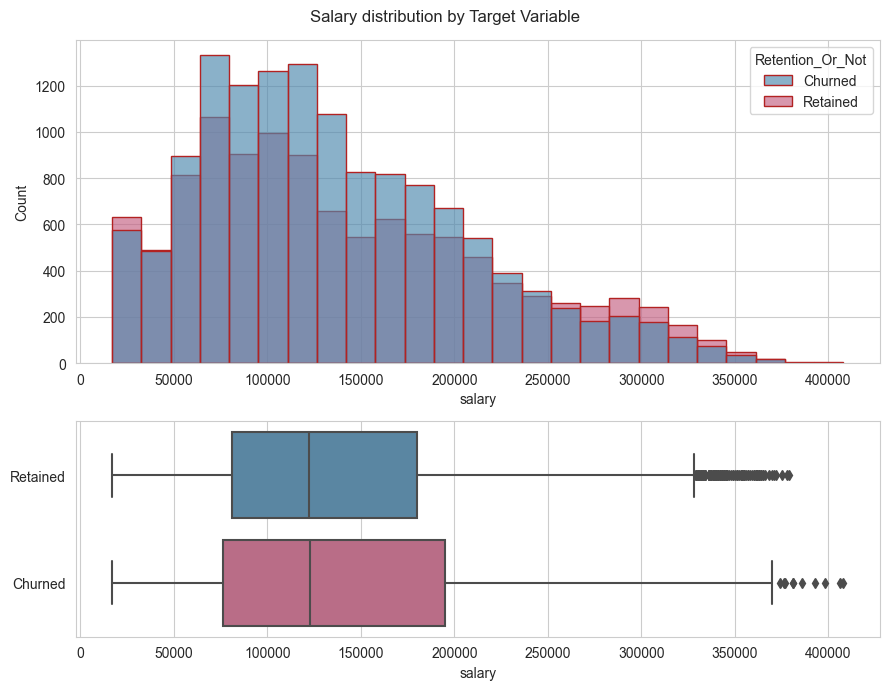

In [96]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(9, 7),gridspec_kw={'height_ratios': (.6, .4)})

sns.histplot(data=df,x="salary",hue='Retention_Or_Not',bins=25,alpha=0.66,edgecolor='firebrick',kde=False,ax=ax1)
sns.boxplot(x="salary", y='Retention_Or_Not', data=df,ax=ax2)
ax2.set_ylabel('')
ax2.set_yticklabels(['Retained', 'Churned'])

plt.suptitle("Salary distribution by Target Variable")
plt.tight_layout()

<AxesSubplot: xlabel='seniority', ylabel='Count'>

<AxesSubplot: xlabel='seniority', ylabel='Retention_Or_Not'>

Text(0, 0.5, '')

[Text(0, 0, 'Retained'), Text(0, 1, 'Churned')]

Text(0.5, 0.98, 'Seniority distribution by Target Variable')

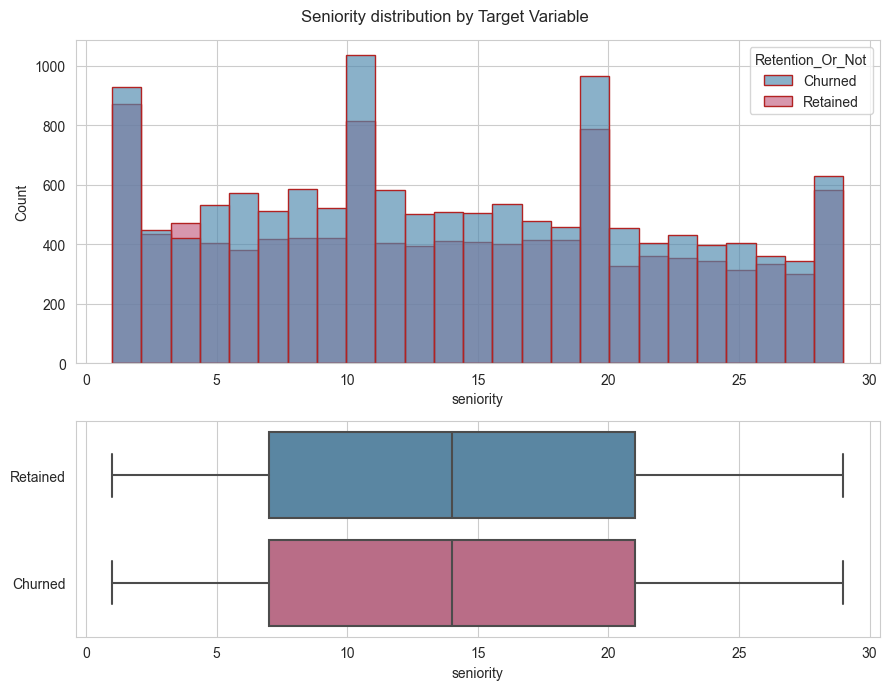

In [97]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(9, 7),gridspec_kw={'height_ratios': (.6, .4)})

sns.histplot(data=df,x="seniority",hue='Retention_Or_Not',bins=25,alpha=0.66,edgecolor='firebrick',kde=False,ax=ax1)
sns.boxplot(x="seniority", y='Retention_Or_Not', data=df,ax=ax2)
ax2.set_ylabel('')
ax2.set_yticklabels(['Retained', 'Churned'])

plt.suptitle("Seniority distribution by Target Variable")
plt.tight_layout()

# Questions

## Q1. Estimate employee headcount, for each company, on each day

In [64]:
unique_date = pd.date_range(start='2011-01-24', end='2015-12-13', freq='D')
unique_company = sorted(df['company_id'].unique())
employee_headcount=[]

for date in unique_date:
    for idx in unique_company:
        total_join = len(df[(df['join_date'] <= date) & (df['company_id'] == idx)])
        total_quit = len(df[(df['quit_date'] <= date) & (df['company_id'] == idx)])
        employee_headcount.append(total_join - total_quit)
      
table2 = pd.DataFrame({'day': [date for date in unique_date for idx in unique_company], 
                      'company_id': [idx for date in unique_date for idx in unique_company],
                      'employee_headcount': employee_headcount},
                     columns=['day', 'company_id', 'employee_headcount'])

In [65]:
table2.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


In [69]:
unique_date = pd.date_range(start='2011-01-24', end='2015-12-13', freq='D')
unique_company = sorted(df['company_id'].unique())

table3 = pd.DataFrame({'day': [date for date in unique_date for idx in unique_company], 
                      'company_id': [idx for date in unique_date for idx in unique_company],
                      'employee_headcount': [len(df[(df['join_date'] <= date) & (df['company_id'] == idx)]) -
                                             len(df[(df['quit_date'] <= date) & (df['company_id'] == idx)]) 
                                             for date in unique_date for idx in unique_company]},
                     columns=['day', 'company_id', 'employee_headcount'])

In [70]:
table3.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


## Q2. What are the main factors that drive employee churn? Do they make sense? Explain your findings.

No noticeable difference found in seniority between churned and retained employees.
More employees retained when their salary are higher 50,000 OR lower than 250,000.
The Sales department has the highest rate of employee turnover among the six departments.


### Time series Analysis

In [98]:
# Separate stay and quit data
quit_data = df[~df['quit_date'].isnull()]
stay_data = df[df['quit_date'].isnull()]

In [103]:
#see the number of working days for each employee
def duration(d1, d2):
    return round((d2 - d1).dt.days)

quit_data['working_days']=duration(quit_data['join_date'],quit_data['quit_date'])

C:\Users\seagu\AppData\Local\Temp\ipykernel_25568\2888820895.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quit_data['working_days']=duration(quit_data['join_date'],quit_data['quit_date'])


In [127]:
quit_data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,Retained,Retention_Or_Not,working_days
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,Churned,585
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,Churned,340
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,Churned,389
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,Churned,1040
5,509529,4,data_science,14,165000.0,2012-01-30,2013-08-30,0,Churned,578


"Total Working Days for churned employee"

<Figure size 1500x600 with 0 Axes>

<AxesSubplot: xlabel='working_days', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of Working Days')

Text(0, 0.5, 'Frequency')

Text(0.5, 0, 'Working Days')

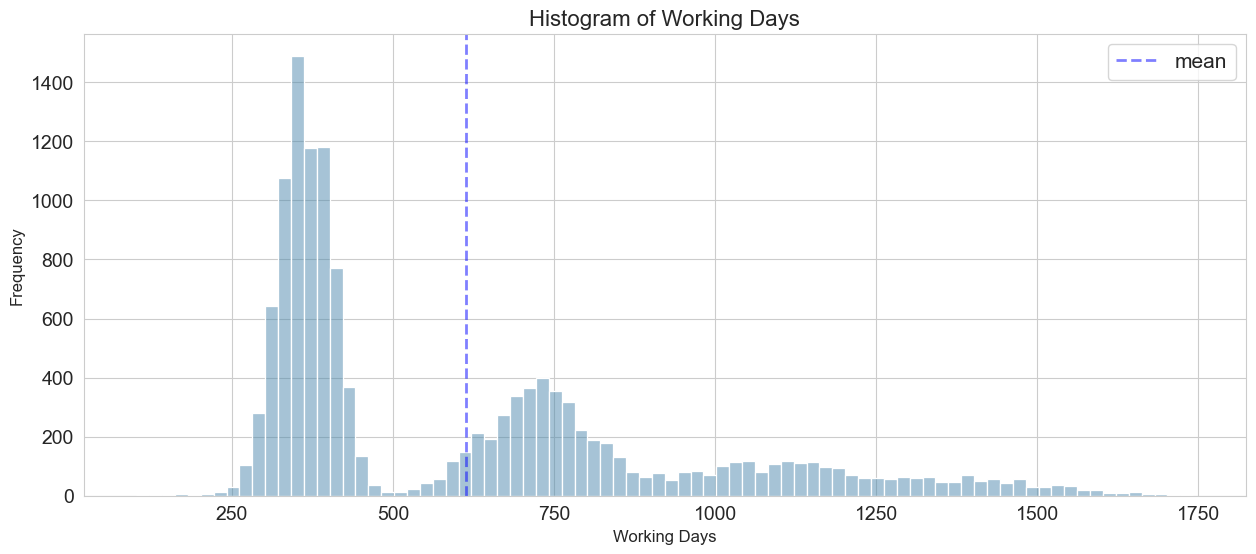

In [126]:
plt.figure(figsize=[15,6])

sns.histplot(data=quit_data, x='working_days',binwidth=20,kde=False,alpha=0.5)
plt.axvline(x=quit_data['working_days'].mean(),color='blue',ls='--', lw=2, label="mean", alpha=0.5)

plt.legend(fontsize=15)
plt.title('Histogram of Working Days', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Working Days', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=14)

"During which month did the most employees resign?"

In [128]:
quit_data['Quit_Year'] = pd.DatetimeIndex(quit_data['quit_date']).year
quit_data['Quit_Month'] = pd.DatetimeIndex(quit_data['quit_date']).month

C:\Users\seagu\AppData\Local\Temp\ipykernel_25568\1935839864.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quit_data['Quit_Year'] = pd.DatetimeIndex(quit_data['quit_date']).year
C:\Users\seagu\AppData\Local\Temp\ipykernel_25568\1935839864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quit_data['Quit_Month'] = pd.DatetimeIndex(quit_data['quit_date']).month


<Figure size 1500x600 with 0 Axes>

<AxesSubplot: xlabel='Quit_Month', ylabel='count'>

Text(0.5, 1.0, 'Countplot of Quit Month')

Text(0, 0.5, 'Frequency')

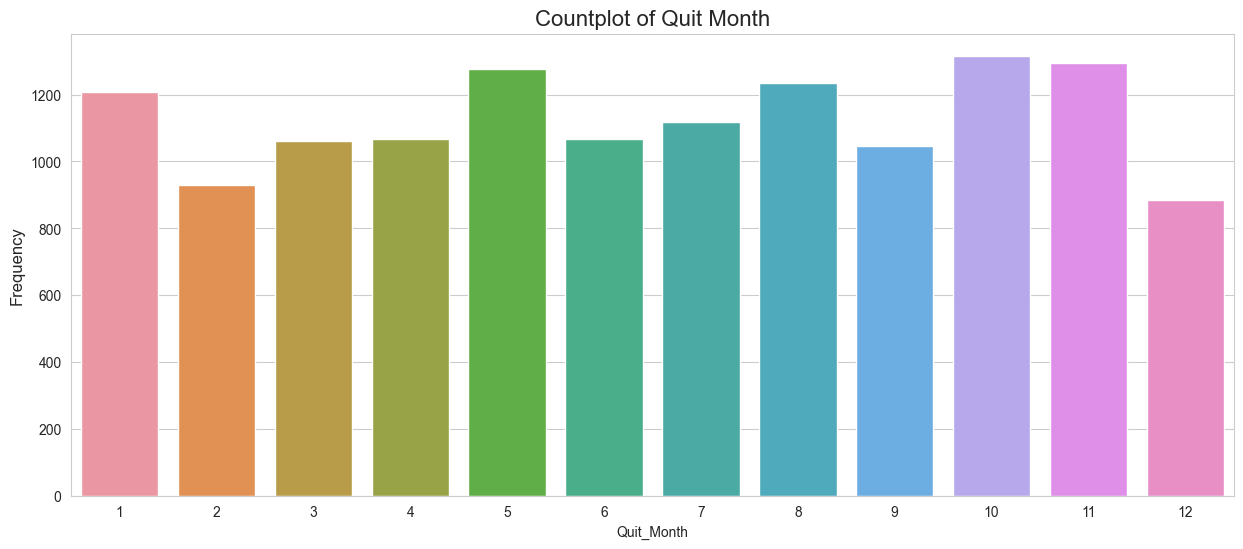

In [135]:
plt.figure(figsize=[15,6])
sns.countplot(data=quit_data, x="Quit_Month")
plt.title('Countplot of Quit Month', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.show()

<AxesSubplot: xlabel='Quit_Year', ylabel='count'>

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Countplot of Quit Year')

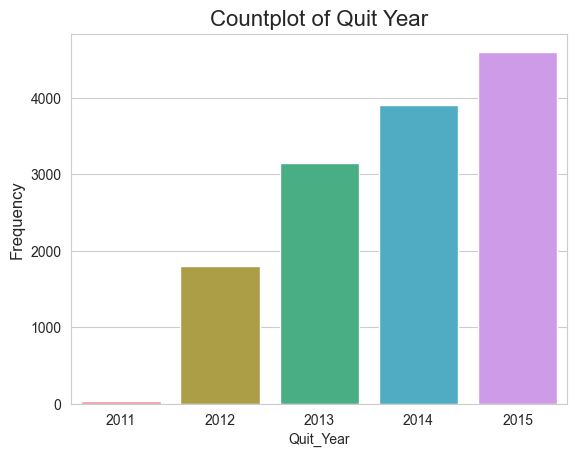

In [138]:
sns.countplot(data=quit_data, x="Quit_Year")
plt.ylabel('Frequency', fontsize=12)
plt.title('Countplot of Quit Year', fontsize=16)
plt.show()

### Decision Tree

##### Packages

In [23]:
import sklearn
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import tree

In [11]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, plot_confusion_matrix, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report
import scikitplot as skplt

#### Data processing

In [12]:
df['Quit_Year'] = pd.DatetimeIndex(df['quit_date']).year
df['Quit_Month'] = pd.DatetimeIndex(df['quit_date']).month

df['Join_Year'] = pd.DatetimeIndex(df['join_date']).year
df['Join_Month'] = pd.DatetimeIndex(df['join_date']).month

In [13]:
#see the number of working days for each employee
from datetime import date, timedelta

def duration(d1, d2):
    if pd.isnull(d2):
        d2 = pd.Timestamp.today()
    return round((d2 - d1).days)

df['working_days'] = df.apply(lambda x: duration(x['join_date'], x['quit_date']), axis=1)

In [14]:
data=df.drop(['Retention_Or_Not','join_date','quit_date','employee_id'],axis=1)
data.head()

,company_id,dept,seniority,salary,Retained,Quit_Year,Quit_Month,Join_Year,Join_Month,working_days
0,7,customer_service,28,89000.0,0,2015.0,10.0,2014,3,585
1,7,marketing,20,183000.0,0,2014.0,4.0,2013,4,340
2,4,marketing,14,101000.0,1,NaN,NaN,2014,10,3040
3,7,customer_service,20,115000.0,0,2013.0,6.0,2012,5,389
4,2,data_science,23,276000.0,0,2014.0,8.0,2011,10,1040


In [15]:
X = df.drop('Retained', axis = 1)
y = df['Retained'] 

In [16]:
# Create Transformer
column_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=10),
            ["seniority","salary","working_days"]),

        ("onehot_categorical", OneHotEncoder(),
            ["dept","Quit_Year","Quit_Month","Join_Year","Join_Month"]),

        ("passthrough_numeric", "passthrough",
            ["company_id"]),
    ],
    remainder="drop",
)

# Fit and Transform
X_prepared=column_trans.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19760, 73) (19760,)
(4940, 73) (4940,)


#### Extracting Feature Names

In [18]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    
    
    # Get columns and bin edges
    def pair_bin_edges_columns(bins_edges, columns):
        all_edge_column = []
        for index in range(len(columns)):
            bin_edge = bins_edges[index]
            column = columns[index]
            
            pair_bin_edge = []
            # match consecutive bin edges together
            for first, second in zip(bin_edge, bin_edge[1:]):
                pair_bin_edge.append((first, second))
            
            bin_edge_column = [column +": ["+ str(edge[0]) +", "+ str(edge[1])+")"  for edge in pair_bin_edge]
            all_edge_column.extend(bin_edge_column)
        return all_edge_column
    
    
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            
            # For transformers that create bins
            if hasattr(trans, 'bin_edges_'):
                bins_edges = trans.bin_edges_
                pairs_edges_columns = pair_bin_edges_columns(bins_edges, column)
            if column is None:
                return []
            else:
                return [name + "__" + f for f in pairs_edges_columns]
        return [name + "__" + f for f in trans.get_feature_names(column)]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [19]:
feature_names =get_feature_names(column_trans)
feature_names

C:\Users\seagu\AppData\Local\Temp\ipykernel_6636\4172062041.py:47: UserWarning: Transformer binned_numeric (type KBinsDiscretizer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

#### Modeling

In [20]:
dtc = DecisionTreeClassifier()

#Grid Search for Decision Tree
params = {'max_depth': [2, 3, 5, 10, 20],'min_samples_leaf': [5, 10, 20, 50, 100],'criterion': ["gini", "entropy"]}

#we care more about recall rate in our model, since FN can cause the real estate loss money, but FP just lost an investment opportunity 
DT_Classfier_grid = GridSearchCV(estimator=dtc, param_grid=params,cv=4, n_jobs=-1, verbose=1, scoring = "f1")
DT_Classfier_grid.fit(X_train, y_train)


Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='f1', verbose=1)

In [21]:
print(f'Decision Tree:\n\t *best params: {DT_Classfier_grid.best_params_}\n\t *best score: {DT_Classfier_grid.best_score_}')

Decision Tree:
	 *best params: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5}
	 *best score: 1.0


In [22]:
#### Using Optimal values of Hyperparameters
best_dtc = DecisionTreeClassifier(max_depth=2,min_samples_leaf=5,criterion='gini')
best_dtc.fit(X_train, y_train)
best_dtc_predicted = best_dtc.predict(X_test)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)

In [24]:
# Visualization
features = list(X_train.columns)
targets = ['Retained', 'Quit']
dot_data = tree.export_graphviz(best_dtc, out_file=None, feature_names=features, class_names=targets, 
                                filled=True, rounded=True, special_characters=True, )  
graph = graphviz.Source(dot_data)
graph

AttributeError: columns not found

## Q3. If you could add to this data set just one variable that could help explain employee churn,what would that be?

In [ ]:
col_name=get_feature_names(preprocessor)
col_name

In [ ]:
# Visualization
features = list(X_train.columns)
targets = ['Not quit', 'Quit']
dot_data = tree.export_graphviz(best_dtc, out_file=None, feature_names=features, class_names=targets, 
                                filled=True, rounded=True, special_characters=True, )  
graph = graphviz.Source(dot_data)
graph